# **Sales Performance Report of Retail Sales**

<p> Going to take a look at a retail dataset spanning four years of transactions (2011 to 2014). This dataset provides data on global sales spanning technology, furniture, and office supplies. <p>

### Key Takeaways 
- There's a trending increase of sales over the years. 
- New York and Los Angeles are the cities with most sales across all cateogies.
- Technology is the most dominant category across all markes.
- Sales and Profit trends show an increase between November and December with a slight decrease in July.
- The consumer segment makes the most profit.
- Shipping cost affects sales as we can see that they are strongly correlated.

### Suggestions to company stakeholders based on the findings

- Stop selling products where the profit is negative as that is a loss to the company.
- Lower discounts in cities where there are high discounts with low profits.
- To increase customer satisfaction, the relationship between shipping mode and cost needs improvement.
- Increase product marketing and advertising in regions and countries with low sales.

In [651]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

df = pd.read_csv('../Global Store Sales Analysis/global_store_sales.csv',  encoding='ISO-8859-1')

## Explore and Clean Dataframe

<p> When exploring a dataframe, it's best to get a preview of the data to see what you'll need to clean up or transform. Let's get a preview of some of the rows, see what columns we have, and check the data types </p>

In [652]:
df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


<p> Appears there's 24 columns and 51,290 entries aka orders. There's quite a bit of information to work with there spanning product info, shipping costs, sales, profit, and geographic data. </p>

In [653]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

<p> Let's check for null or missing data. In data science, null data can be a big issue and can provide inaccurate analysis. Seems Postal Code has a lot of missing data so we'll drop this column. In terms of our analysis, we won't need this column so dropping it won't make an impact. We'll drop Row ID as its not needed either. </p>

In [654]:
df.isnull().sum().sort_values(ascending=False)

Postal Code       41296
Row ID                0
Region                0
Shipping Cost         0
Profit                0
Discount              0
Quantity              0
Sales                 0
Product Name          0
Sub-Category          0
Category              0
Product ID            0
Market                0
Order ID              0
Country               0
State                 0
City                  0
Segment               0
Customer Name         0
Customer ID           0
Ship Mode             0
Ship Date             0
Order Date            0
Order Priority        0
dtype: int64

In [655]:
df.drop(columns=['Row ID', 'Postal Code'], inplace=True)

list(df)

['Order ID',
 'Order Date',
 'Ship Date',
 'Ship Mode',
 'Customer ID',
 'Customer Name',
 'Segment',
 'City',
 'State',
 'Country',
 'Market',
 'Region',
 'Product ID',
 'Category',
 'Sub-Category',
 'Product Name',
 'Sales',
 'Quantity',
 'Discount',
 'Profit',
 'Shipping Cost',
 'Order Priority']

<p> From this correlation graph, we can see the coefficient between Shipping Cost and Sales is 0.77 showing a strong positive correlation and means that Shipping Cost affects Sales greatly. The coefficient between Shipping Cost and Profit is 0.35 showing only moderation correlation, probably because the shipping cost is only a small portion of the total profit and has a lesser impact. </p>

<Axes: >

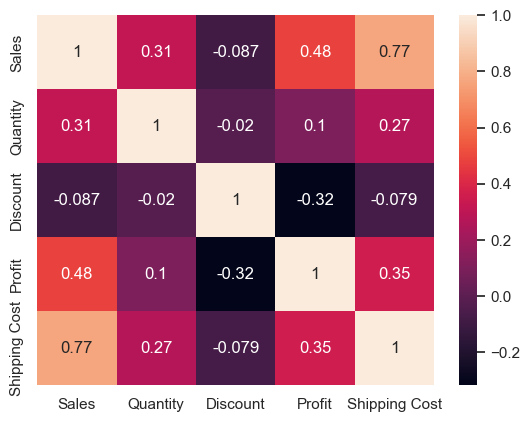

In [656]:
corr_matrix = df.corr(numeric_only=True)

sns.heatmap(corr_matrix, annot=True)

In [657]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Order ID        51290 non-null  object        
 1   Order Date      51290 non-null  datetime64[ns]
 2   Ship Date       51290 non-null  object        
 3   Ship Mode       51290 non-null  object        
 4   Customer ID     51290 non-null  object        
 5   Customer Name   51290 non-null  object        
 6   Segment         51290 non-null  object        
 7   City            51290 non-null  object        
 8   State           51290 non-null  object        
 9   Country         51290 non-null  object        
 10  Market          51290 non-null  object        
 11  Region          51290 non-null  object        
 12  Product ID      51290 non-null  object        
 13  Category        51290 non-null  object        
 14  Sub-Category    51290 non-null  object        
 15  Pr

## Add Necessary Columns

<p> How much each unit costs is important in sales so we'll add a Unit Cost column and divide Sales by Quantity. We'll also extract the Month and Year from the Order Date column, these will be useful for analyzing later </p>

In [658]:
df['Month'] = df['Order Date'].dt.month
df['Year'] = df['Order Date'].dt.year

df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Month,Year
0,CA-2012-124891,2012-07-31,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,...,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,7,2012
1,IN-2013-77878,2013-02-05,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,...,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,2,2013
2,IN-2013-71249,2013-10-17,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,...,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,10,2013
3,ES-2013-1579342,2013-01-28,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,...,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,1,2013
4,SG-2013-4320,2013-11-05,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,...,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,11,2013


In [659]:
df['Unit Price'] = df['Sales'] / df['Quantity']

df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,...,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Month,Year,Unit Price
0,CA-2012-124891,2012-07-31,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,...,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical,7,2012,329.950
1,IN-2013-77878,2013-02-05,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,...,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical,2,2013,412.155
2,IN-2013-71249,2013-10-17,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,...,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium,10,2013,575.019
3,ES-2013-1579342,2013-01-28,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,...,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium,1,2013,578.502
4,SG-2013-4320,2013-11-05,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,...,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical,11,2013,354.120


## Least Bought & Profitable

<p> In sales, it's important to know which of your products are the worst performing and least profitable. Let's create a dataframe showing the least bought products using Quantity and then we'll sort that dataframe again in descending order by products with most negative Profit values. It appears Corporate Technology products are the least profitable and are the ones that should be taken a look at and improve upon by either reducing discounts, lowering shipping costs, or not offering all together if that makes more financial sense. </p>

In [675]:
# Select the required columns
selected_columns = ['Product Name', 'Sales', 'Unit Price' ,'Profit', 'Shipping Cost', 'Discount', 'Quantity', 'Segment', 'Category']

# Create a new DataFrame with the selected columns
least_bought_products = df[selected_columns]

# Sort the DataFrame by Quantity in ascending order to get the least bought products
least_bought_products = least_bought_products.sort_values(by='Quantity')

# Display the DataFrame
least_bought_products.head(10).style.hide(axis="index")

Product Name,Sales,Unit Price,Profit,Shipping Cost,Discount,Quantity,Segment,Category
"Enermax Message Books, Multicolor",7.173000,7.173000,-15.567000,0.850000,0.700000,1,Consumer,Office Supplies
"Acme Shears, Serrated",46.620000,46.620000,1.380000,4.360000,0.000000,1,Consumer,Office Supplies
"Tenex Frame, Black",109.980000,109.980000,5.490000,8.440000,0.000000,1,Consumer,Furniture
"Apple Smart Phone, Full Size",636.210000,636.210000,178.110000,33.230000,0.000000,1,Consumer,Technology
"Apple Speaker Phone, with Caller ID",49.320000,49.320000,-43.170000,2.490000,0.600000,1,Corporate,Technology
"Hamilton Beach Stove, Red",542.340000,542.340000,244.050000,63.760000,0.000000,1,Consumer,Office Supplies
"Enermax Memory Card, Bluetooth",114.390000,114.390000,18.300000,3.660000,0.000000,1,Corporate,Technology
"Binney & Smith Pencil Sharpener, Easy-Erase",27.930000,27.930000,3.060000,2.300000,0.000000,1,Corporate,Office Supplies
"SanDisk Computer Printout Paper, 8.5 x 11",33.930000,33.930000,3.720000,4.250000,0.000000,1,Corporate,Office Supplies
"Hon Bag Chairs, Set of Two",42.660000,42.660000,6.630000,5.330000,0.100000,1,Corporate,Furniture


In [676]:
least_bought_products.sort_values(by='Profit').head(10).style.hide(axis="index")

Product Name,Sales,Unit Price,Profit,Shipping Cost,Discount,Quantity,Segment,Category
Cubify CubeX 3D Printer Double Head Print,4499.985000,899.997000,-6599.978000,451.630000,0.700000,5,Consumer,Technology
"Motorola Smart Phone, Cordless",3085.344000,257.112000,-4088.376000,51.890000,0.600000,12,Corporate,Technology
Cubify CubeX 3D Printer Triple Head Print,7999.980000,1999.995000,-3839.990400,674.820000,0.500000,4,Corporate,Technology
GBC DocuBind P400 Electric Binding System,2177.584000,272.198000,-3701.892800,172.070000,0.800000,8,Consumer,Office Supplies
Lexmark MX611dhe Monochrome Laser Printer,2549.985000,509.997000,-3399.980000,120.310000,0.700000,5,Home Office,Technology
"Hoover Stove, White",3399.660000,283.305000,-3059.820000,286.870000,0.500000,12,Corporate,Office Supplies
"Apple Smart Phone, Full Size",3499.155000,318.105000,-3009.435000,333.100000,0.500000,11,Home Office,Technology
Ibico EPK-21 Electric Binding System,1889.990000,377.998000,-2929.484500,129.510000,0.800000,5,Corporate,Office Supplies
"Barricks Conference Table, Rectangular",2171.160000,271.395000,-2750.280000,390.090000,0.700000,8,Corporate,Furniture
Cubify CubeX 3D Printer Double Head Print,1799.994000,899.997000,-2639.991200,219.620000,0.700000,2,Consumer,Technology


## Shipping Costs

<p> Let's get the average Shipping Cost by Region to see which areas we can try to improve upon and increase sales. Looks like the Asian continent is the most expensive to ship to with 3 of the top 5 regions being from Asia. </p>

In [662]:
# Group by Region and calculate the average shipping cost for each region
average_shipping_cost_by_region = df.groupby('Region')['Shipping Cost'].mean().reset_index()

# Sort the data by average shipping cost in descending order
average_shipping_cost_by_region = average_shipping_cost_by_region.sort_values(by='Shipping Cost', ascending=False)

# Resetting the index and removing the index column
average_shipping_cost_by_region.style.hide(axis="index")

Region,Shipping Cost
North Asia,40.646112
Central Asia,38.003003
Oceania,34.593780
Southeast Asia,29.937948
North,27.476299
Central,26.710494
East,25.542001
South,25.353509
West,23.887687
Caribbean,21.059260


## Visualize the Data

### Market and Region Comparison

<p> Looking at Sales and Profit by Market, we sell the most to the APAC market, followed by the EU and US. 

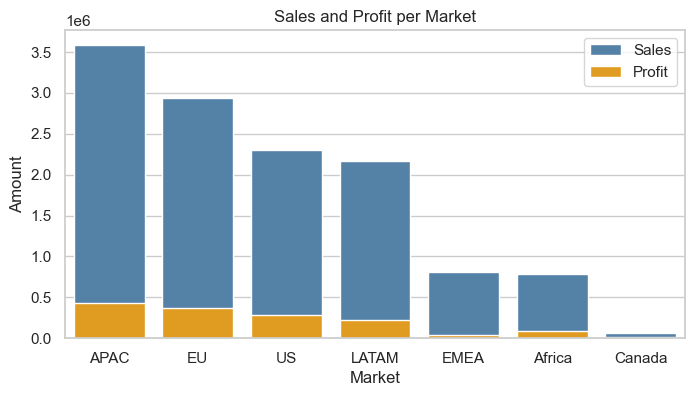

In [684]:
market_data = df.groupby('Market')[['Sales', 'Profit']].sum().reset_index()

# Sort the data by Sales in descending order
market_data = market_data.sort_values(by='Sales', ascending=False)

sns.set(style="whitegrid")

plt.figure(figsize=(8, 4))

bar_plot = sns.barplot(x='Market', y='Sales', data=market_data, color='steelblue', label='Sales')
bar_plot = sns.barplot(x='Market', y='Profit', data=market_data, color='orange', label='Profit')

plt.ylabel('Amount')
plt.title('Sales and Profit per Market')
plt.legend()

plt.show()

<p> Separating Sales by Category and Market, it appears Technology and Furniture products are the best selling. 

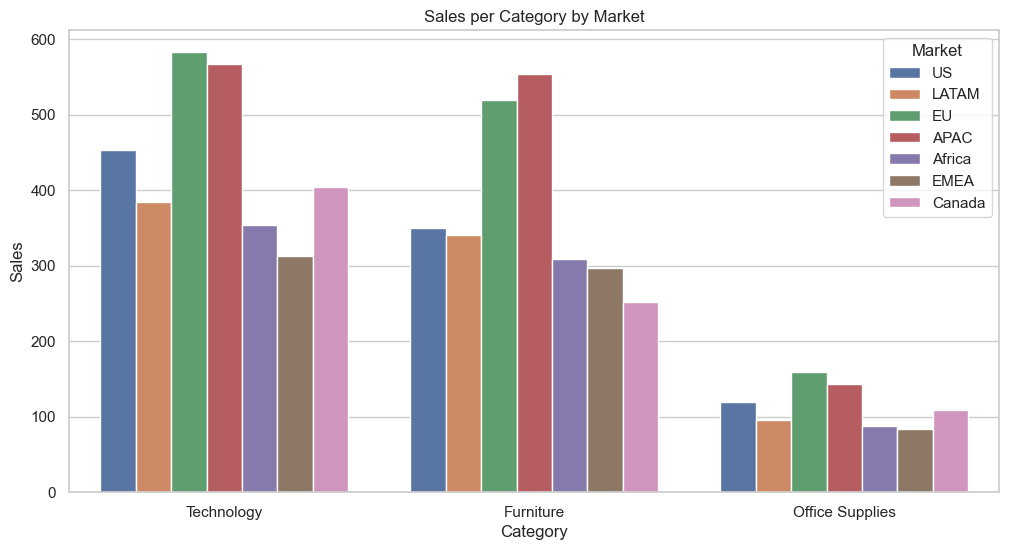

In [679]:
plt.figure(figsize=(12,6))

# For our graph, error bars aren't necessary so removed those
sns.barplot(data=df, x='Category', y='Sales', hue='Market', errorbar=None)

plt.title('Sales per Category by Market')

plt.show()

<p> Showing percentage of Sales by Region, it appears Central leads by a wide margin with South and North regions following next. </p>

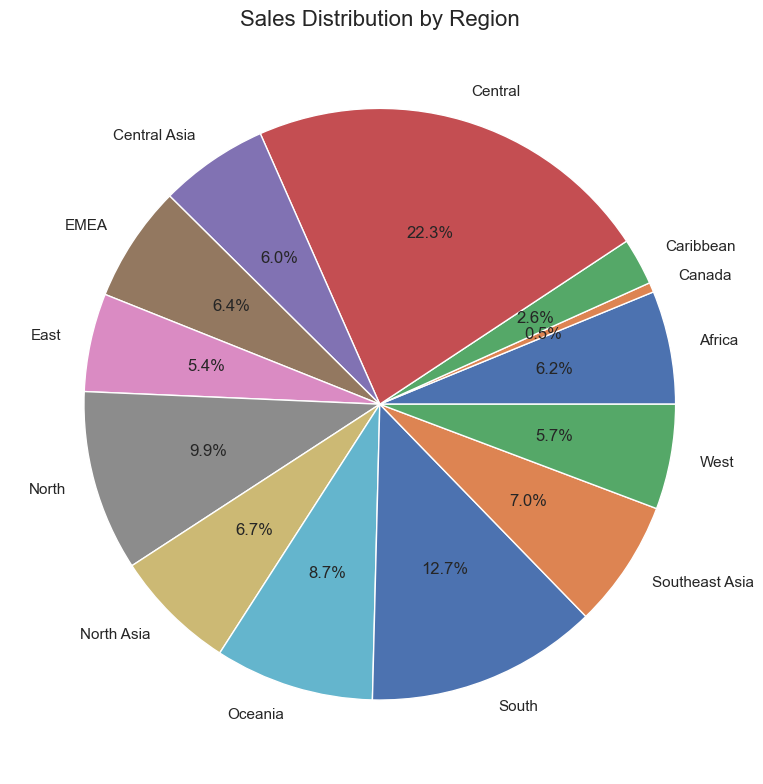

In [698]:
market_sales = df.groupby('Region')['Sales'].sum()

plt.figure(figsize=(10,8))
plt.pie(market_sales, labels=market_sales.index, autopct='%1.1f%%', radius=1.0, labeldistance=1.1)
plt.title('Sales Distribution by Region', fontsize=16)

plt.tight_layout()
plt.show()

## Time Series Analysis

<p> Plotting Sales by Year, it appears the best months for sales are September, November, and December. The weakest months are February, April, July, and January. This appears to be a consistent trend across the years. Looks like there's a seasonal increase in sales around the holidays. </p>

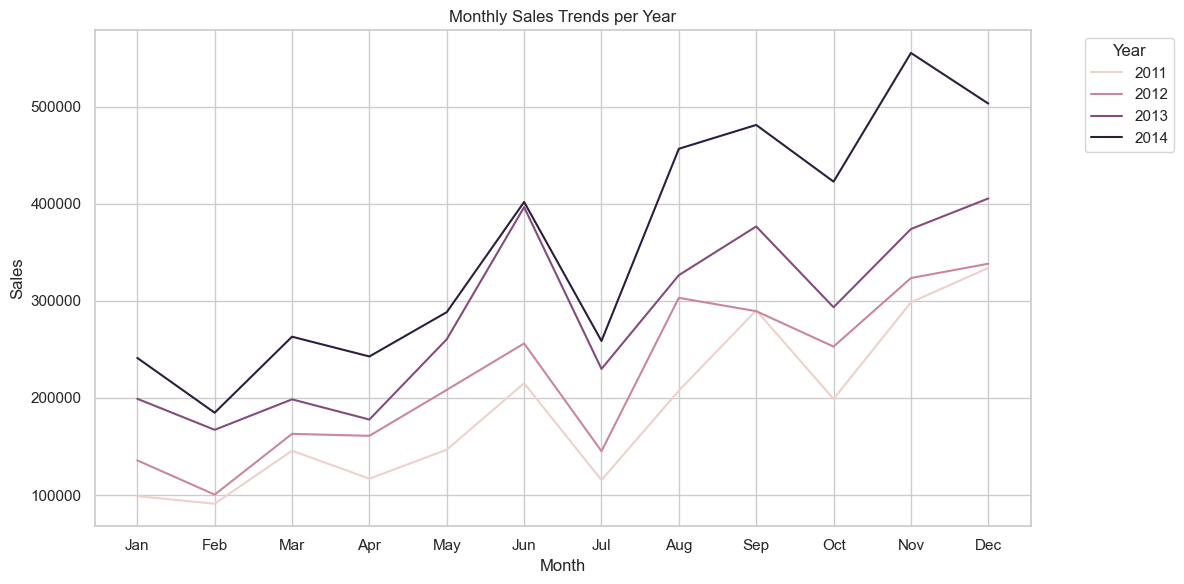

In [678]:
# Group by Year and Month, then calculate total sales for each month
monthly_sales = df.groupby(['Year', 'Month'])['Sales'].sum().reset_index()

# Create a line plot
plt.figure(figsize=(12, 6))
line_plot = sns.lineplot(x='Month', y='Sales', hue='Year', data=monthly_sales)

plt.title('Monthly Sales Trends per Year')

plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()

plt.show()

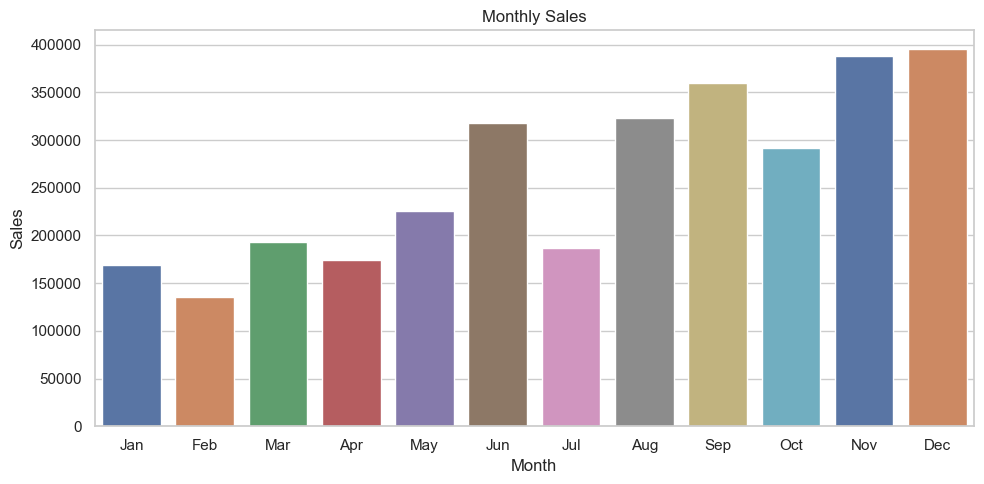

In [704]:
plt.figure(figsize=(10, 5))

bar_plot = sns.barplot(x='Month', y='Sales', data=monthly_sales, palette='deep', errorbar=None)

plt.title('Monthly Sales')

# Adding names to the months instead of 0-12 values for better clarity
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

<p> Visualizing Sales by Year, it seems we have an increasing trend in Sales over time. Definitely something we want to see in a healthy business </p>

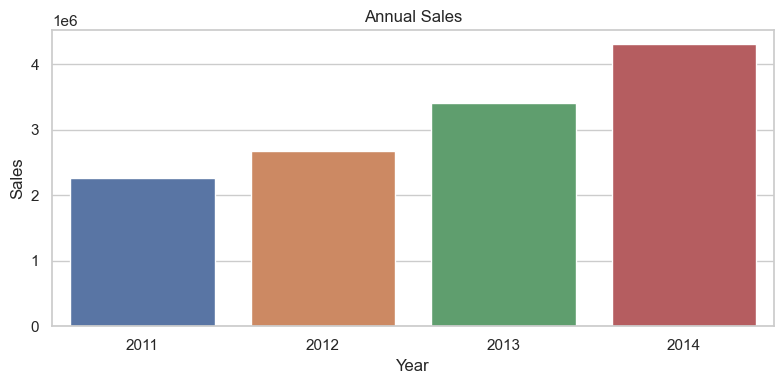

In [700]:
annual_sales = df.groupby('Year')['Sales'].sum().reset_index()

plt.figure(figsize=(8, 4))
bar_plot = sns.barplot(x='Year', y='Sales', data=annual_sales, palette='deep')

plt.title('Annual Sales')

plt.tight_layout()
plt.show()

### Product Performance

<p> In order to visualize profit margin, we'll need to divide Profit by Sales and express it as a percentage. Based on the box plot visual, there are a few key takeaways that would need to be addressed by the business. As seen from earlier, there are a lot of products that are being sold with negative profits, these are hurting the business and can be seen as outlier points. Appears Office Supplies and Technology products produce the most profits on average with Furniture being the worst. Furniture tends to be held onto for a long time and the business may need to keep offering these products at lesser prices and higher discounts, which could explain all the products with negative profit. </p>

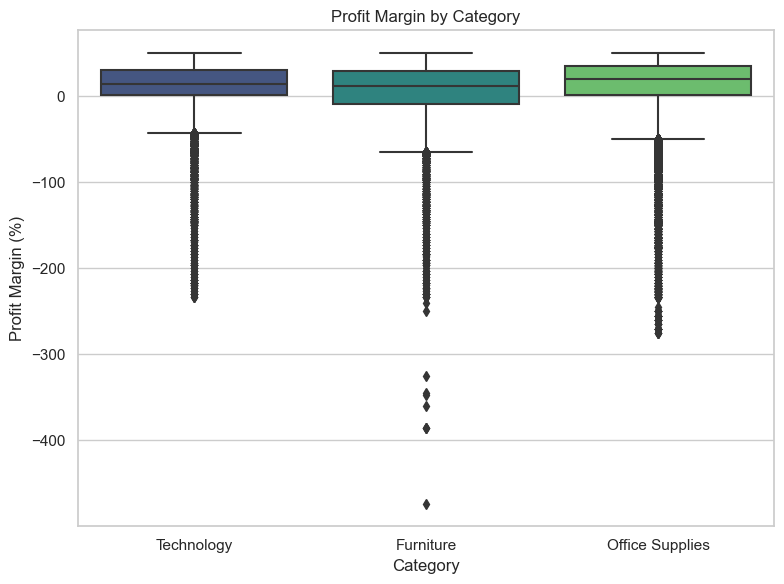

In [717]:
# Calculate profit margin for each row by dividing Profit by Sales
df['Profit Margin'] = (df['Profit'] / df['Sales']) * 100

plt.figure(figsize=(8, 6))
box_plot = sns.boxplot(x='Category', y='Profit Margin', data=df, palette='viridis')

plt.ylabel('Profit Margin (%)')
plt.title('Profit Margin by Category')

plt.tight_layout()
plt.show()

<p> Product performance is something that is important to know for every business. To visualize this we'll plot a heatmap of Sales separated by each products Category and Sub-Category. The plot shows that bookcases and chairs are the best performing Furniture Products. For Office Supplies, appliances and storage products performed the best. For Technology products, phones and copiers we're the best performing. </p>

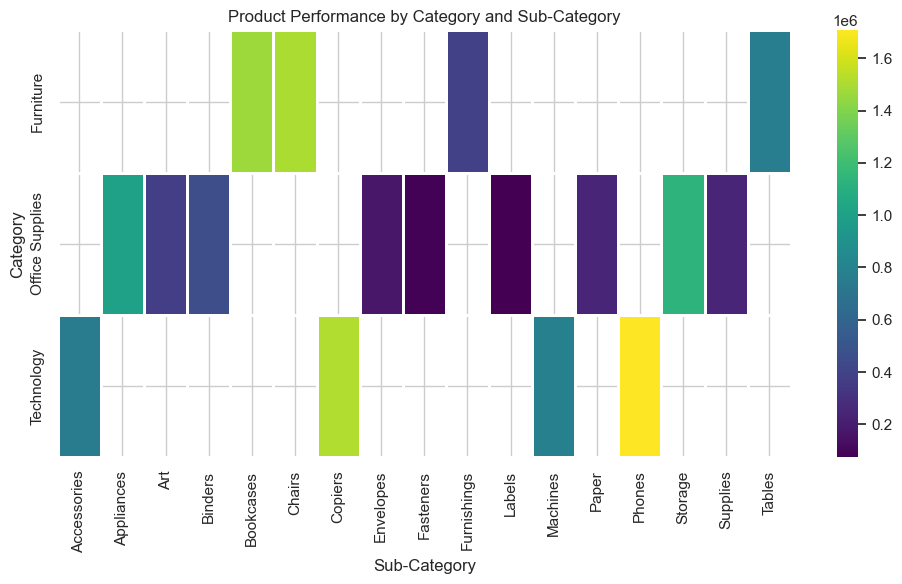

In [741]:
# Create a pivot table with Category and Sub-Category as indices and sum of Sales as values
sales_pivot = pd.pivot_table(df, values='Sales', index=['Category', 'Sub-Category'], aggfunc='sum').reset_index()

# Sort the pivot table by Sales in descending order
sales_pivot = sales_pivot.sort_values(by='Sales', ascending=False)

# Reshape the pivot table into a heatmap-friendly format
product_heatmap = sales_pivot.pivot(index='Category', columns='Sub-Category', values='Sales')

plt.figure(figsize=(10, 6))

heatmap = sns.heatmap(product_heatmap, fmt=".2f", cmap="viridis", linewidths=.8)

plt.title('Product Performance by Category and Sub-Category')

plt.tight_layout()
plt.show()

## Customer Segmentation

<p> Plotting Profit by Segment, it appears Consumer products are the most profitable by a decent margin. </p>

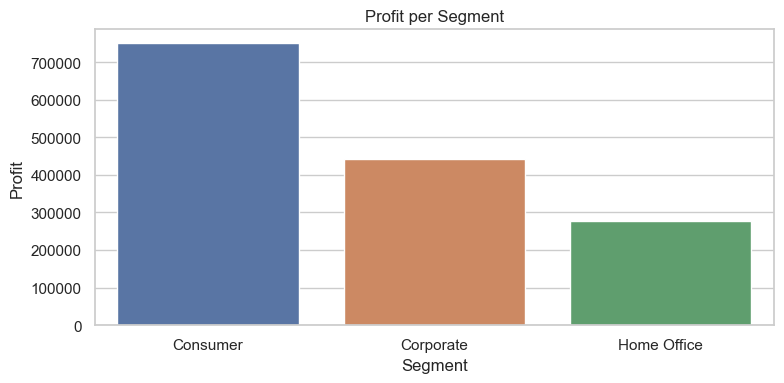

In [706]:
segment_profit = df.groupby('Segment')['Profit'].sum().reset_index()

plt.figure(figsize=(8, 4))

bar_plot = sns.barplot(x='Segment', y='Profit', data=segment_profit, palette='deep')

plt.title('Profit per Segment')

plt.tight_layout()
plt.show()

<p> Plotting the sum of Quantity of Sales by City, we can visualize what the best selling cities are. From this, it seems New York and Los Angeles have the most orders, followed by Philadelphia, San Francisco, and Manila. </p>

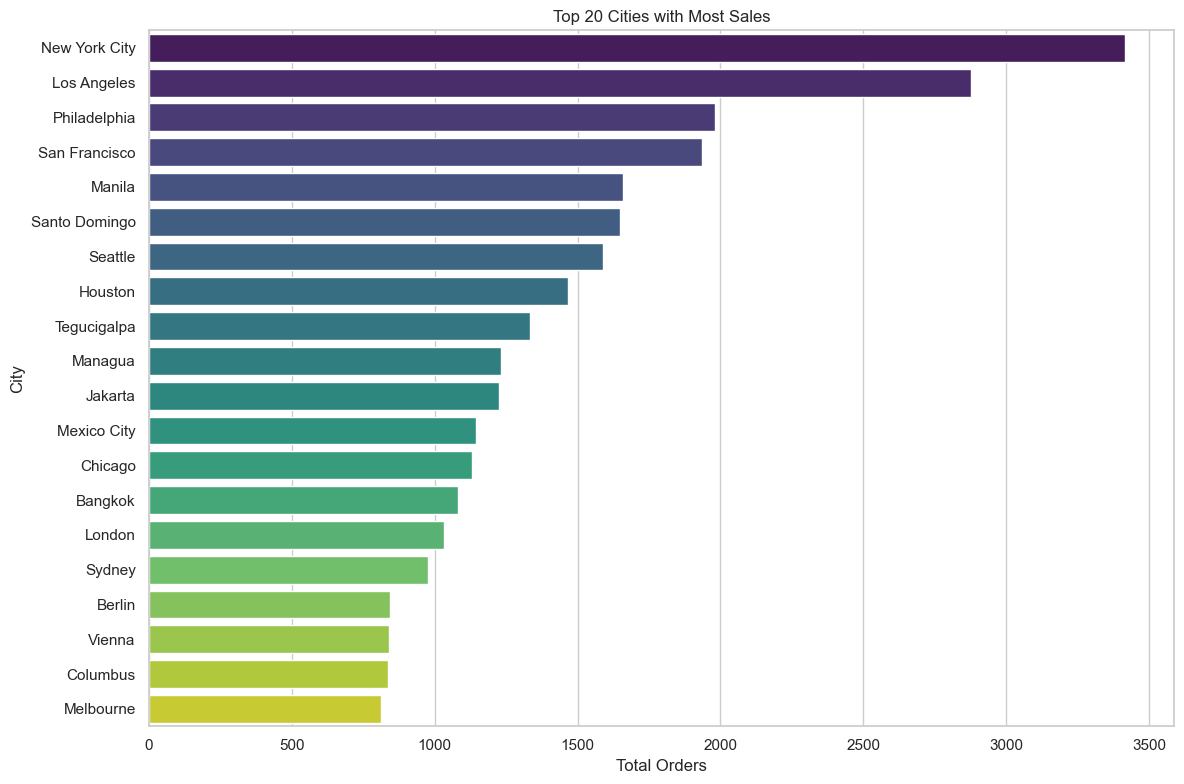

In [707]:
city_orders = df.groupby('City')['Quantity'].sum().reset_index()

city_orders = city_orders.sort_values(by='Quantity', ascending=False).head(20)

plt.figure(figsize=(12, 8))

bar_plot = sns.barplot(x='Quantity', y='City', data=city_orders, palette='viridis')

plt.xlabel('Total Orders')
plt.title('Top 20 Cities with Most Sales')

plt.tight_layout()
plt.show()

<p> Separating Ship Mode by quantity of sales, we can see which are most popular. It was a fair assumption to make that Standard shipping would be the most common being the cheapest, with each following Ship Mode decreasing as shipping costs increases with priority. </p>

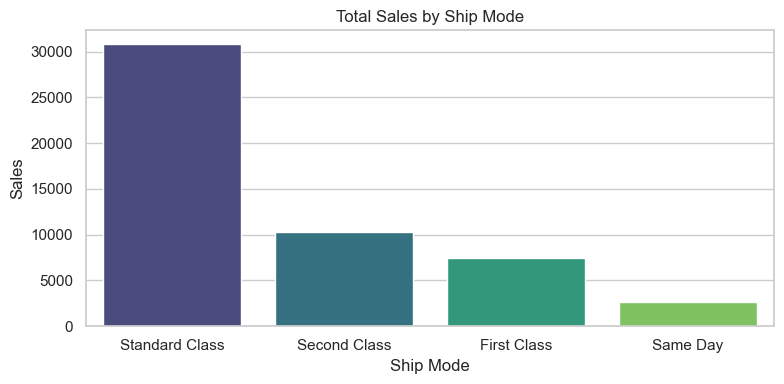

In [743]:
# Get the count of each value in 'Ship Mode'
ship_mode_counts = df['Ship Mode'].value_counts()

plt.figure(figsize=(8, 4))

bar_plot = sns.barplot(x=ship_mode_counts.index, y=ship_mode_counts.values, palette='viridis')

plt.xlabel('Ship Mode')
plt.ylabel('Sales')
plt.title('Total Sales by Ship Mode')

plt.tight_layout()
plt.show()

## Customer Retention Analysis

<p> Was curious to see what the customer retention rate was. Based on the graph, it appears custom retention needs some working on. What we would want to see here is either a flat or increasing line. An upward slope would indicate that we have increasing returning customers throughout the year. A flat slope would indicate that percentage of returning customers is consistent throughout the year, this isn't the best thing, but not as bad as a decreasing slope. </p>

<p> Looking at the graph, it seems we have customers returning in the spring months, with a hard drop off in the winter months. This is interesting given the months with most sales we're the winter months, but could indicate there's many new customers during this time instead of repeat ones. Considering the inventory of products, I think this would make sense since many technology and furniture products last a long time and don't require the customer returning often.</p>

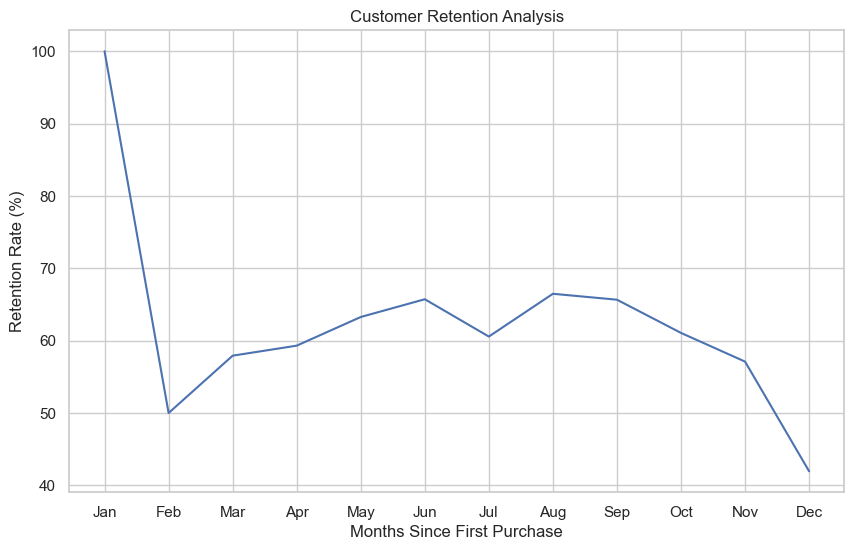

In [672]:
first_purchase_df = df.groupby('Customer ID')['Month'].min().reset_index()
first_purchase_df.columns = ['Customer ID', 'FirstPurchaseMonth']

# Merge the original DataFrame with the first purchase information based by Customer ID
df = pd.merge(df, first_purchase_df, on='Customer ID')

# Calculate the number of months since the first purchase
df['MonthsSinceFirstPurchase'] = (df['Month'] - df['FirstPurchaseMonth']).astype(int)

# Calculate the number of unique customers for each month since the first purchase
customer_retention = df.groupby('MonthsSinceFirstPurchase')['Customer ID'].nunique().reset_index()

# Calculate retention rate
customer_retention['RetentionRate'] = customer_retention['Customer ID'] / customer_retention['Customer ID'].max() * 100

# Plot the customer retention curve
plt.figure(figsize=(10, 6))
plt.plot(customer_retention['MonthsSinceFirstPurchase'], customer_retention['RetentionRate'])
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.xlabel('Months Since First Purchase')
plt.ylabel('Retention Rate (%)')
plt.title('Customer Retention Analysis')

plt.grid(True)
plt.show()